# Libraries

In [13]:
import pandas as pd
import glob
import requests
import time

In [36]:
import matplotlib.pyplot as plt

In [71]:
import seaborn as sns

# Data Loading

In [27]:
# load the streaming history data, where 'ts' column is datetime
stream_df = pd.read_csv('datasets/tracks_df_processed.csv', parse_dates=['ts'])

C:\Users\Kim\AppData\Local\Temp\ipykernel_2228\2479707888.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  stream_df = pd.read_csv('datasets/tracks_df_processed.csv', parse_dates=['ts'])


In [28]:
#check the number of rows and columns we have in streaming_df
print(stream_df.shape)
print(stream_df.columns)

(127961, 12)
Index(['ts', 'platform', 'ms_played', 'track_name', 'artist_name',
       'album_name', 'track_id', 'reason_start', 'reason_end', 'shuffle',
       'skipped', 'offline'],
      dtype='object')


In [29]:
# load the track info data
track_info_df = pd.read_csv('datasets/tracks_info_df.csv')

In [30]:
print(track_info_df.shape)
print(track_info_df.columns)

(5172, 6)
Index(['track_id', 'name', 'artistName', 'release_date', 'popularity',
       'duration_ms'],
      dtype='object')


In [31]:
# load the track features data
track_features_df = pd.read_csv('datasets/tracks_features_df.csv')

In [32]:
print(track_features_df.shape)
print(track_features_df.columns)

(5165, 13)
Index(['track_id', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature'],
      dtype='object')


# Analysing trends of the data

## total minutes streamed per year

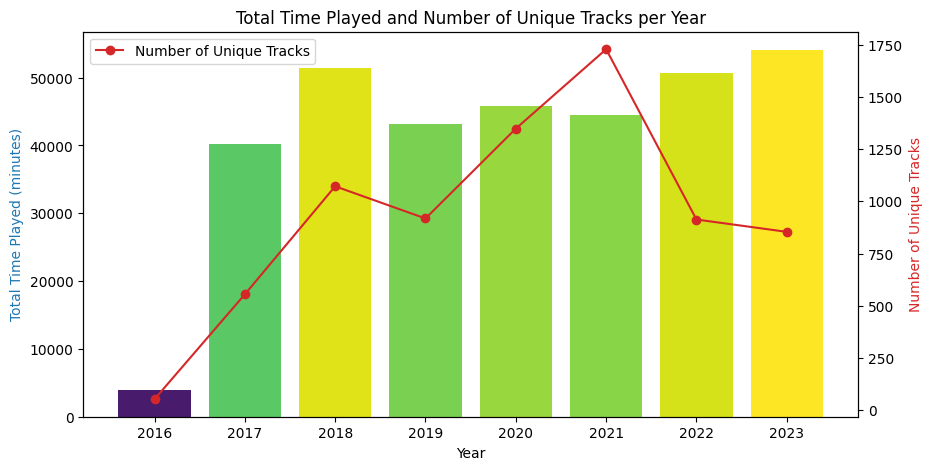

In [61]:
# Group by year and sum the ms_played in minutes
grouped_data = stream_df.groupby(stream_df['ts'].dt.year)['ms_played'].sum().div(60000)
grouped_counts = stream_df.groupby(stream_df['ts'].dt.year)['track_id'].nunique()

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the sum of ms_played in minutes grouped by year with colored bars
bars = ax1.bar(grouped_data.index, grouped_data, color=plt.cm.viridis(grouped_data.values / grouped_data.max()), width=0.8)

# Set plot labels and title for the first y-axis
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Time Played (minutes)', color='tab:blue')
ax1.set_title('Total Time Played and Number of Unique Tracks per Year')

# Create a second y-axis for the counts
ax2 = ax1.twinx()
ax2.plot(grouped_counts.index, grouped_counts, color='tab:red', marker='o', label='Number of Unique Tracks')

# Set plot labels for the second y-axis
ax2.set_ylabel('Number of Unique Tracks', color='tab:red')

# Display the legend
ax2.legend(loc='upper left')

# Show the plot
plt.show()


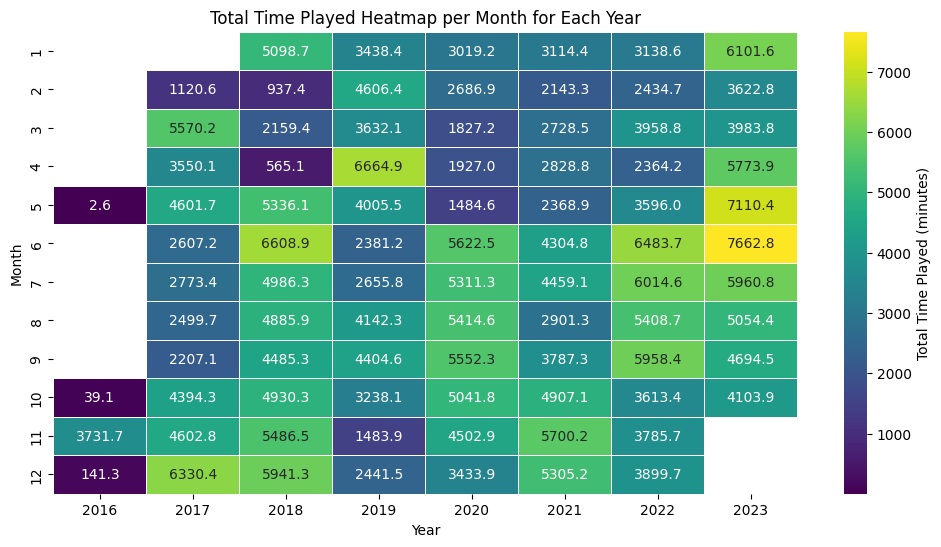

In [72]:
# Group by year and month and sum the ms_played in minutes
grouped_data_monthly = stream_df.groupby([stream_df['ts'].dt.year, stream_df['ts'].dt.month])['ms_played'].sum().div(60000)

# Reshape the data for plotting
pivot_data = grouped_data_monthly.unstack(level=0)

# Create a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data, cmap="viridis", annot=True, fmt=".1f", linewidths=.5, cbar_kws={'label': 'Total Time Played (minutes)'})

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Month')
plt.title('Total Time Played Heatmap per Month for Each Year')

# Show the plot
plt.show()


as we can see from the visualizations, [2018, 2023] are the top 2 year where I listened music on spotify the most and [2016, 2017] are the least. Note that the length of data for 2016 and 2023 are not a complete one-year long, since I started my spotify subscribtion on May 2016 and received the streaming history data on October 2023

## most listened artist and track per year

In [152]:
# find the top 5 most listened artists per year
top_artists = stream_df.groupby([stream_df['ts'].dt.year, 'artist_name'])['ms_played'].sum().div(60000).reset_index()
top_artists = top_artists.rename(columns={'ts': 'year', 'ms_played': 'minutes'})
top_artists = top_artists.sort_values(['year', 'minutes'], ascending=[True, False])
top5_artists = top_artists.groupby('year').head(5)
top5_artists

,year,artist_name,minutes
29,2016,Ylvis,1011.990267
28,2016,Virtual Riot,835.094683
2,2016,Au5,358.598283
7,2016,Hyper Potions,355.384950
23,2016,The Chainsmokers,161.256083
127,2017,In Love With a Ghost,10910.546983
103,2017,Foster The People,1929.053783
204,2017,Pink Guy,1925.746667
85,2017,Ed Sheeran,1863.483133
34,2017,Aimer,1709.588150


In [98]:
# find the top 5 most listened tracks per year
top_tracks = stream_df.groupby([stream_df['ts'].dt.year, 'track_id'])['ms_played'].sum().div(60000).reset_index()

# get the track_name using the track_id from the track_info_df
top_tracks = top_tracks.merge(track_info_df[['track_id', 'name', 'artistName']], on='track_id', how='left')
# create a new column with the track name and artist name
top_tracks['track'] = top_tracks['artistName'] + ' - ' + top_tracks['name']
# remove unnecessary columns
top_tracks = top_tracks.drop(columns=['track_id', 'name', 'artistName'])
# rename the columns
top_tracks = top_tracks.rename(columns={'ts': 'year', 'ms_played': 'minutes'})
# sort the values by year and minutes
top_tracks = top_tracks.sort_values(['year', 'minutes'], ascending=[True, False])
top5_tracks = top_tracks.groupby('year').head(5)
top5_tracks

,year,minutes,track
47,2016,834.998950,Virtual Riot - Time Stops
49,2016,479.813383,Ylvis - The Cabin
51,2016,355.384950,Hyper Potions - Unbreakable (feat. Danyka Nadeau)
40,2016,266.580850,Ylvis - Stonehenge
42,2016,265.596033,Ylvis - The Fox (What Does the Fox Say?)
595,2017,1929.053783,Foster The People - Pumped Up Kicks
131,2017,1449.877183,In Love With a Ghost - Interdimensional Portal...
500,2017,1227.475417,In Love With a Ghost - Crystal
80,2017,1218.392617,Fight Like Apes - I'm Beginning To Think You P...
427,2017,874.446717,In Love With a Ghost - Flowers


In [202]:
top_artists.columns

Index(['year', 'artist_name', 'minutes'], dtype='object')

In [233]:
# get the top 10 artist for each year
top10_artists = top_artists.groupby('year').head(10).reset_index(drop=True)

# create a pivot table and set year as the column and minutes as the values
top10_artists_pivot = top10_artists.pivot_table(index='artist_name', columns='year', values='minutes').round(2).reset_index()

# add 'total' column to pivot table except the 'artist_name' column
top10_artists_pivot['total appearance'] = top10_artists_pivot.iloc[:, 1:].count(axis = 1)
top10_artists_pivot['total minutes'] = top10_artists_pivot.iloc[:, 1:-1].sum(axis = 1)
top10_artists_pivot.fillna(0, inplace = True)

In [234]:
top10_artists_pivot.sort_values('total minutes', ascending=False).head(10)

year,artist_name,2016,2017,2018,2019,2020,2021,2022,2023,total appearance,total minutes
6,Bishop Briggs,0.0,0.00,7951.53,4352.43,5502.82,2539.33,2488.81,0.00,5,22834.92
22,In Love With a Ghost,0.0,10910.55,3422.96,1318.06,1932.91,2180.37,0.00,0.00,5,19764.85
48,Us The Duo,0.0,0.00,0.00,0.00,11927.04,5015.01,2623.32,0.00,3,19565.37
32,Orla Gartland,0.0,0.00,0.00,0.00,0.00,0.00,12528.82,7009.47,2,19538.29
55,dodie,0.0,0.00,0.00,0.00,0.00,0.00,7596.10,7488.41,2,15084.51
9,Daniela Andrade,0.0,0.00,0.00,0.00,6549.73,6131.10,0.00,619.12,3,13299.95
34,Pomplamoose,0.0,0.00,0.00,0.00,0.00,0.00,0.00,10452.78,1,10452.78
12,Darren Korb,0.0,0.00,0.00,0.00,1613.77,6099.71,0.00,0.00,2,7713.48
10,Danilla,0.0,0.00,0.00,6274.42,0.00,0.00,0.00,0.00,1,6274.42
8,Chilli Beans.,0.0,0.00,0.00,0.00,0.00,0.00,6201.34,0.00,1,6201.34
